In [129]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [131]:
data = pd.read_csv("dly532_processed.csv")
data = data.sample(frac=1).reset_index(drop=True)

In [132]:
y = data["Rainy"]
X = data.drop(["Rainy","date"], axis=1).values

In [133]:
#数据集进行划分,使用80%的训练数据来训练，20%的数据用来测试，
def stacking(X,y):
    dev_cutoff =int(len(y) * 4/5)
    X_dev = X[:dev_cutoff]
    y_dev = y[:dev_cutoff]
    X_test = X[dev_cutoff:]
    y_test = y[dev_cutoff:]
    
    n_trees = 10
    n_folds = 5
    
    #第一层学习器
    clfs = [
        RandomForestClassifier(n_estimators = n_trees, criterion = 'gini'),
        ExtraTreesClassifier(n_estimators = n_trees * 2, criterion = 'gini'),
        GradientBoostingClassifier(n_estimators = n_trees),
        AdaBoostClassifier(random_state=2)
    ]
        
    # 数据交叉验证训练clf准备
    skf = list(StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=None).split(X_dev, y_dev))
    
    # 第二层的训练数据 blend_train
    blend_train = np.zeros((X_dev.shape[0], len(clfs))) # Number of training data x Number of classifiers
    blend_test = np.zeros((X_test.shape[0], len(clfs))) # Number of testing data x Number of classifiers
    
    print ('X_test.shape = %s' % (str(X_test.shape)))
    print ('blend_train.shape = %s' % (str(blend_train.shape)))
    print ('blend_test.shape = %s' % (str(blend_test.shape)))
    
    # 对每一个学习器进行训练，得到blend_train 和 blend_test
    for j, clf in enumerate(clfs):
        print ('Training classifier [%s]' % (j))
        blend_test_j = np.zeros((X_test.shape[0], n_folds)) # Number of testing data x Number of folds , we will take the mean of the predictions later
        roc_aou_fpr = []
        roc_aou_tpr = []
        for i, (train_index, test_index) in enumerate(skf):
            print ('Fold [%s]' % (i))
            
            # This is the training and validation set
            X_cv_train = X_dev[train_index]
            y_cv_train = y_dev[train_index]
            X_cv_test = X_dev[test_index]
            y_cv_test = y_dev[test_index]
            
            clf.fit(X_cv_train, y_cv_train)
            
            # This output will be the basis for our blended classifier to train against,
            # which is also the output of our classifiers
            blend_train[test_index, j] = clf.predict(X_cv_test)
            blend_test_j[:, i] = clf.predict(X_test)
            prediction = clf.predict(X_test)
            
        # Take the mean of the predictions of the cross validation set
        blend_test[:, j] = blend_test_j.mean(1)
    
     # 用 blend_train, y_dev 去训练第二层的学习器 LogisticRegression
    bclf = LogisticRegression()
    bclf.fit(blend_train, y_dev)
    
    # 基于训练的二级分类器，预测测试集 blend_test，并得到 score：
    y_test_predict = bclf.predict(blend_test)
    score = accuracy_score(y_test, y_test_predict)
    return score, y_test, y_test_predict

In [134]:
def plot_confusion_matrix(matrix):
    f = plt.figure(figsize=(3,3))
    ax = f.add_subplot()
    ax.matshow(matrix,cmap=plt.cm.Blues,alpha=0.3)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(x=j,y=i,s=matrix[i,j],va='center',ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')

In [135]:
def roc_auc_plot():
    f = plt.figure(figsize=(5,5))
    ax = f.add_subplot()
    roc_auc_score(y_test, y_test_predict)
    fpr, tpr, _ = roc_curve(y_test, y_test_predict)
    roc_auc = auc(fpr, tpr)
    ax.plot(
        fpr, tpr,
        color = "darkorange",
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Some extension of Receiver operating characteristic to multiclass")
    ax.legend(loc="lower right")

In [136]:
def appraise(y_test, y_test_predict):
    accuracy = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict, average='macro')
    f1 = f1_score(y_test, y_test_predict,average='weighted')
    confusion_mat = confusion_matrix(y_test, y_test_predict)
    
    print('Accuracy = %s' %(accuracy))
    print('Recall Score = %s' %(recall))
    print('F1 Score = %s' %(f1))
    
    plot_confusion_matrix(confusion_mat)
    roc_auc_plot()

Iteration [0]
X_test.shape = (1522, 18)
blend_train.shape = (6087, 4)
blend_test.shape = (1522, 4)
Training classifier [0]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [1]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [2]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [3]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Best score = 0.835742444152431
------------------------------
Accuracy = 0.835742444152431
Recall Score = 0.7993332051983382
F1 Score = 0.8298689286451052


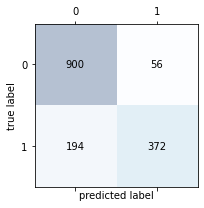

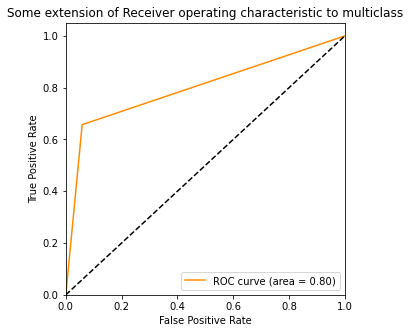

In [137]:
best_score = 0.0

# run many times to get a better result, it's not quite stable.
for i in range(1):
    print ('Iteration [%s]' % (i))
    score, y_test, y_test_predict = stacking(X, y)
    best_score = max(best_score, score)

print ('Best score = %s' % (best_score))
print ('------------------------------')

appraise(y_test, y_test_predict)
plt.show()